In [1]:
# Todo: stage, change structure

In [2]:
%env CUDA_VISIBLE_DEVICES=0
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import imageio
import moviepy.editor as mpy
import os
import cv2

BATCH_SIZE = 500
SAMPLE_COL = 8 #16
SAMPLE_ROW = 8 #16
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW
IMG_H = 64 #28
IMG_W = 64 #28
IMG_C = 3 #1
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)
Z_DIM = 128
BUF = 65536
DC_LR = 2.5e-04
DC_EPOCH = 100 #256
W_LR = 2.0e-04
W_EPOCH = 256 #256
BZ = (BATCH_SIZE, Z_DIM)
WClipLo = -0.01
WClipHi = 0.01

env: CUDA_VISIBLE_DEVICES=0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 0x2400)])

In [4]:
# Load dataset
import glob

PATH = os.path.abspath('.')+'/img_align_celeba_png/'
F = '*.png'
files = glob.glob(os.path.join(PATH, F))

# dataset = np.zeros((1,64,64,3))
dataset = []
# print(dataset.shape)

temp = 0
for myFile in files:
    image = cv2.imread(myFile)
    resize_image = cv2.resize(image, (64, 64))
    resize_image = np.array(resize_image.astype(np.float32))
    if temp >= 30000:
        break
    dataset.append(resize_image)
    print('\r',myFile, temp, "  ", end='')
    temp = temp + 1

# dataset = np.delete(dataset, 0, 0)

dataset_np = np.array(dataset)

 /home/stevrng/DL/Lab14/img_align_celeba_png/046829.png 29999   8      959       1929      4428    5126      9744    10597     12125                23411       24352   25045   

In [5]:
dataset_np.shape

(30000, 64, 64, 3)

In [6]:
# (train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()
# iTrain = train_images.reshape(-1, 28, 28, 1).astype(np.float32)

iTrain = dataset_np

# Normalizing the images to the range of [0., 1.]
iTrain = iTrain / 255.0

dsTrain = tf.data.Dataset.from_tensor_slices(iTrain).shuffle(BUF).batch(BATCH_SIZE, True)

# Utility function
def utPuzzle(imgs, row, col, path = None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out
  
def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t : imgs[int(n * t)], duration = duration)
    clip.write_gif(fname, fps = n)

In [7]:
iTrain[0].shape

(64, 64, 3)

In [8]:
def GAN(sp, zd):
    # Shape
    xh, xw, xc = sp
    zh = xh // 4
    zw = xw // 4
        
    # Model
    return keras.Sequential([
        keras.layers.Dense(units  =  1024, input_shape = (zd,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units  =  zh * zw << 8),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape = (zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters = 32,
            kernel_size = 5,
            strides = 2,
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters = xc,
            kernel_size = 5,
            strides = 2,
            padding = "SAME",
            activation = keras.activations.sigmoid
        ),
    ]), keras.Sequential([
        keras.layers.Conv2D(
            filters = 32,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME",
            input_shape = sp,
        ),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Conv2D(
            filters = 128,
            kernel_size = 5,
            strides = (2, 2),
            padding = "SAME"
        ),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        #keras.layers.Dropout(0.3),
        keras.layers.Flatten(),
        keras.layers.Dense(units  =  1024),
        keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units  =  1),
    ])

s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [9]:
lambd = 10
alpha = 0.0001
beta1 = 0
beta2 = 0.9

In [10]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
opg = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)
opd = keras.optimizers.Adam(learning_rate=alpha, beta_1=beta1, beta_2=beta2)

@tf.function
def WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpg:
        #9
        c0 = WG(z, training = True)
        # c1 comes from dataset
        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
    #10
    gg = tpg.gradient(lg, WG.trainable_variables)
    #11 (RMS)
    opg.apply_gradients(zip(gg, WG.trainable_variables))
    
    return lg, ld

In [11]:
@tf.function
def WDTrain(c1):
    print("WD")
    z = tf.random.normal(BZ)
    e = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0., 1.)
    
    with tf.GradientTape() as tpd:
        c0 = WG(z, training = True)
        
        z1 = WD(c1, training = True)
        z0 = WD(c0, training = True)
        
        ld = tf.reduce_mean(z0)
        lg = - ld
        ld = ld - tf.reduce_mean(z1)
        
        ev = c1+e*(c0-c1)

        # penalty
        with tf.GradientTape() as tpd2:
            tpd2.watch(ev)
            pred = WD(ev, training = True)

        grad = tpd2.gradient(pred, [ev])[0]
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]),axis=1)
        penalty = lambd * tf.math.square(norm-1)
        penalty = tf.reduce_mean(penalty)
        
        ld = ld + penalty

    gd = tpd.gradient(ld, WD.trainable_variables)
    opd.apply_gradients(zip(gd, WD.trainable_variables))
    
    return lg, ld

WTrain = (
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WDTrain,
    WGTrain
)

WCritic = len(WTrain)

Start Epoch:  0    Time:  2019-12-12 11:12:42.337410
WD
WD
Start Epoch:  1    Time:  2019-12-12 11:13:12.210948
Start Epoch:  2    Time:  2019-12-12 11:13:35.044057
Start Epoch:  3    Time:  2019-12-12 11:13:57.914410
Start Epoch:  4    Time:  2019-12-12 11:14:21.375332
Start Epoch:  5    Time:  2019-12-12 11:14:45.267033
Start Epoch:  6    Time:  2019-12-12 11:15:08.873245
Start Epoch:  7    Time:  2019-12-12 11:15:32.084059
Start Epoch:  8    Time:  2019-12-12 11:15:55.471507
Start Epoch:  9    Time:  2019-12-12 11:16:19.032517
Start Epoch:  10    Time:  2019-12-12 11:16:42.539246
Start Epoch:  11    Time:  2019-12-12 11:17:05.978941
Start Epoch:  12    Time:  2019-12-12 11:17:29.586987
Start Epoch:  13    Time:  2019-12-12 11:17:53.095275
Start Epoch:  14    Time:  2019-12-12 11:18:16.698701
Start Epoch:  15    Time:  2019-12-12 11:18:40.190870
Start Epoch:  16    Time:  2019-12-12 11:19:03.685171
Start Epoch:  17    Time:  2019-12-12 11:19:27.087490
Start Epoch:  18    Time:  2019-

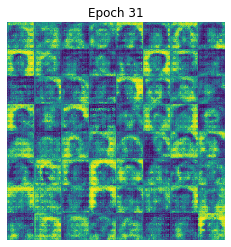

Start Epoch:  32    Time:  2019-12-12 11:25:19.367535
Start Epoch:  33    Time:  2019-12-12 11:25:42.883575
Start Epoch:  34    Time:  2019-12-12 11:26:06.423533
Start Epoch:  35    Time:  2019-12-12 11:26:29.864155
Start Epoch:  36    Time:  2019-12-12 11:26:53.381585
Start Epoch:  37    Time:  2019-12-12 11:27:16.967300
Start Epoch:  38    Time:  2019-12-12 11:27:40.429856
Start Epoch:  39    Time:  2019-12-12 11:28:03.992022
Start Epoch:  40    Time:  2019-12-12 11:28:27.438075
Start Epoch:  41    Time:  2019-12-12 11:28:50.894729
Start Epoch:  42    Time:  2019-12-12 11:29:14.341507
Start Epoch:  43    Time:  2019-12-12 11:29:37.792546
Start Epoch:  44    Time:  2019-12-12 11:30:01.279393
Start Epoch:  45    Time:  2019-12-12 11:30:24.743788
Start Epoch:  46    Time:  2019-12-12 11:30:48.172339
Start Epoch:  47    Time:  2019-12-12 11:31:11.578017
Start Epoch:  48    Time:  2019-12-12 11:31:35.069510
Start Epoch:  49    Time:  2019-12-12 11:31:58.693217
Start Epoch:  50    Time:  2

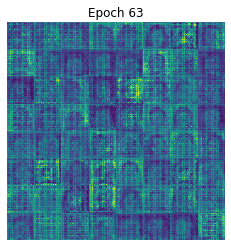

Start Epoch:  64    Time:  2019-12-12 11:37:51.033814
Start Epoch:  65    Time:  2019-12-12 11:38:14.477697
Start Epoch:  66    Time:  2019-12-12 11:38:37.955166
Start Epoch:  67    Time:  2019-12-12 11:39:01.374488
Start Epoch:  68    Time:  2019-12-12 11:39:24.968727
Start Epoch:  69    Time:  2019-12-12 11:39:48.535186
Start Epoch:  70    Time:  2019-12-12 11:40:12.032642
Start Epoch:  71    Time:  2019-12-12 11:40:35.585037
Start Epoch:  72    Time:  2019-12-12 11:40:59.052510
Start Epoch:  73    Time:  2019-12-12 11:41:22.507437
Start Epoch:  74    Time:  2019-12-12 11:41:45.961584
Start Epoch:  75    Time:  2019-12-12 11:42:09.328036
Start Epoch:  76    Time:  2019-12-12 11:42:32.709893
Start Epoch:  77    Time:  2019-12-12 11:42:56.154599
Start Epoch:  78    Time:  2019-12-12 11:43:19.570670
Start Epoch:  79    Time:  2019-12-12 11:43:42.954483
Start Epoch:  80    Time:  2019-12-12 11:44:06.400485
Start Epoch:  81    Time:  2019-12-12 11:44:29.834253
Start Epoch:  82    Time:  2

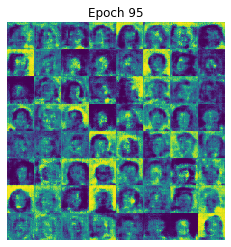

Start Epoch:  96    Time:  2019-12-12 11:50:21.557717
Start Epoch:  97    Time:  2019-12-12 11:50:45.091137
Start Epoch:  98    Time:  2019-12-12 11:51:08.520116
Start Epoch:  99    Time:  2019-12-12 11:51:31.947233
Start Epoch:  100    Time:  2019-12-12 11:51:55.379619
Start Epoch:  101    Time:  2019-12-12 11:52:18.845197
Start Epoch:  102    Time:  2019-12-12 11:52:42.359427
Start Epoch:  103    Time:  2019-12-12 11:53:05.908964
Start Epoch:  104    Time:  2019-12-12 11:53:29.408978
Start Epoch:  105    Time:  2019-12-12 11:53:52.948214
Start Epoch:  106    Time:  2019-12-12 11:54:16.446252
Start Epoch:  107    Time:  2019-12-12 11:54:39.879919
Start Epoch:  108    Time:  2019-12-12 11:55:03.410321
Start Epoch:  109    Time:  2019-12-12 11:55:26.885224
Start Epoch:  110    Time:  2019-12-12 11:55:50.292388
Start Epoch:  111    Time:  2019-12-12 11:56:13.731511
Start Epoch:  112    Time:  2019-12-12 11:56:37.081529
Start Epoch:  113    Time:  2019-12-12 11:57:00.481636
Start Epoch:  

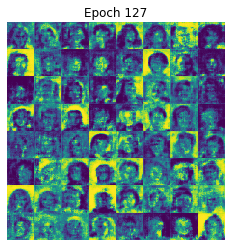

Start Epoch:  128    Time:  2019-12-12 12:02:52.653261
Start Epoch:  129    Time:  2019-12-12 12:03:16.239305
Start Epoch:  130    Time:  2019-12-12 12:03:39.831921
Start Epoch:  131    Time:  2019-12-12 12:04:03.338512
Start Epoch:  132    Time:  2019-12-12 12:04:26.863040
Start Epoch:  133    Time:  2019-12-12 12:04:50.415478
Start Epoch:  134    Time:  2019-12-12 12:05:13.912407
Start Epoch:  135    Time:  2019-12-12 12:05:37.396047
Start Epoch:  136    Time:  2019-12-12 12:06:00.838972
Start Epoch:  137    Time:  2019-12-12 12:06:24.338153
Start Epoch:  138    Time:  2019-12-12 12:06:47.758485
Start Epoch:  139    Time:  2019-12-12 12:07:11.168426
Start Epoch:  140    Time:  2019-12-12 12:07:34.661145
Start Epoch:  141    Time:  2019-12-12 12:07:58.109811
Start Epoch:  142    Time:  2019-12-12 12:08:21.647985
Start Epoch:  143    Time:  2019-12-12 12:08:45.082609
Start Epoch:  144    Time:  2019-12-12 12:09:08.649556
Start Epoch:  145    Time:  2019-12-12 12:09:32.101186
Start Epoc

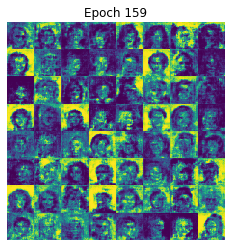

Start Epoch:  160    Time:  2019-12-12 12:15:24.300356
Start Epoch:  161    Time:  2019-12-12 12:15:47.833485
Start Epoch:  162    Time:  2019-12-12 12:16:11.308894
Start Epoch:  163    Time:  2019-12-12 12:16:34.834325
Start Epoch:  164    Time:  2019-12-12 12:16:58.271285
Start Epoch:  165    Time:  2019-12-12 12:17:21.715776
Start Epoch:  166    Time:  2019-12-12 12:17:45.210916
Start Epoch:  167    Time:  2019-12-12 12:18:08.652423
Start Epoch:  168    Time:  2019-12-12 12:18:32.193369
Start Epoch:  169    Time:  2019-12-12 12:18:55.583243
Start Epoch:  170    Time:  2019-12-12 12:19:18.970441
Start Epoch:  171    Time:  2019-12-12 12:19:42.382479
Start Epoch:  172    Time:  2019-12-12 12:20:05.909526
Start Epoch:  173    Time:  2019-12-12 12:20:29.332549
Start Epoch:  174    Time:  2019-12-12 12:20:52.754116
Start Epoch:  175    Time:  2019-12-12 12:21:16.194316
Start Epoch:  176    Time:  2019-12-12 12:21:39.691480
Start Epoch:  177    Time:  2019-12-12 12:22:03.046098
Start Epoc

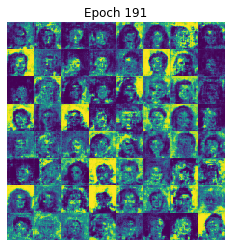

Start Epoch:  192    Time:  2019-12-12 12:27:54.723335
Start Epoch:  193    Time:  2019-12-12 12:28:18.124231
Start Epoch:  194    Time:  2019-12-12 12:28:41.576936
Start Epoch:  195    Time:  2019-12-12 12:29:05.044912
Start Epoch:  196    Time:  2019-12-12 12:29:28.492211
Start Epoch:  197    Time:  2019-12-12 12:29:51.974588
Start Epoch:  198    Time:  2019-12-12 12:30:15.354809
Start Epoch:  199    Time:  2019-12-12 12:30:38.748646
Start Epoch:  200    Time:  2019-12-12 12:31:02.125156
Start Epoch:  201    Time:  2019-12-12 12:31:25.579433
Start Epoch:  202    Time:  2019-12-12 12:31:49.097480
Start Epoch:  203    Time:  2019-12-12 12:32:12.553616
Start Epoch:  204    Time:  2019-12-12 12:32:36.088947
Start Epoch:  205    Time:  2019-12-12 12:32:59.463172
Start Epoch:  206    Time:  2019-12-12 12:33:22.974370
Start Epoch:  207    Time:  2019-12-12 12:33:46.458771
Start Epoch:  208    Time:  2019-12-12 12:34:09.935041
Start Epoch:  209    Time:  2019-12-12 12:34:33.383484
Start Epoc

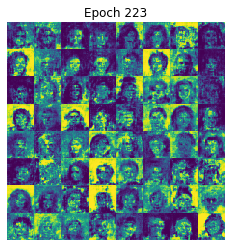

Start Epoch:  224    Time:  2019-12-12 12:40:25.647307
Start Epoch:  225    Time:  2019-12-12 12:40:49.022812
Start Epoch:  226    Time:  2019-12-12 12:41:12.445971
Start Epoch:  227    Time:  2019-12-12 12:41:35.903448
Start Epoch:  228    Time:  2019-12-12 12:41:59.368874
Start Epoch:  229    Time:  2019-12-12 12:42:22.862771
Start Epoch:  230    Time:  2019-12-12 12:42:46.287250
Start Epoch:  231    Time:  2019-12-12 12:43:09.736504
Start Epoch:  232    Time:  2019-12-12 12:43:33.261553
Start Epoch:  233    Time:  2019-12-12 12:43:56.686231
Start Epoch:  234    Time:  2019-12-12 12:44:20.118229
Start Epoch:  235    Time:  2019-12-12 12:44:43.565832
Start Epoch:  236    Time:  2019-12-12 12:45:07.026686
Start Epoch:  237    Time:  2019-12-12 12:45:30.570348
Start Epoch:  238    Time:  2019-12-12 12:45:54.084850
Start Epoch:  239    Time:  2019-12-12 12:46:17.662520
Start Epoch:  240    Time:  2019-12-12 12:46:41.169606
Start Epoch:  241    Time:  2019-12-12 12:47:04.513490
Start Epoc

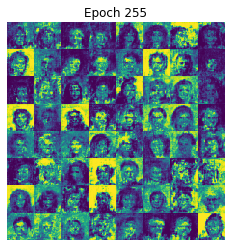

In [12]:
import datetime

wlg = [None] * W_EPOCH
wld = [None] * W_EPOCH
wsp = [None] * W_EPOCH
rsTrain = float(BATCH_SIZE) / float(len(iTrain))
ctr = 0
for ep in range(W_EPOCH):
    print('Start Epoch: ', ep, "   Time: ", datetime.datetime.now())
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = WTrain[ctr](c1)
        ctr += 1
        lgt += lg.numpy()
        ldt += ld.numpy()
        if ctr == WCritic : ctr = 0
    wlg[ep] = lgt * rsTrain
    wld[ep] = ldt * rsTrain
    
    out = WG(s, training = False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/w_%04d.png" % ep
    )
    wsp[ep] = img
    if ep & 0x1F == 0x1F:
        
        plt.imshow(img[..., 0])
        plt.axis("off")
        plt.title("Epoch %d" % ep)
        plt.show()

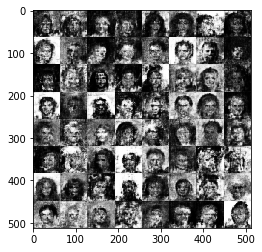

In [13]:
plt.imshow(img[..., 0], cmap='gray')

In [14]:
utMakeGif(np.array(wsp), "imgs/wgan.gif", duration = 2)

t:   2%|▏         | 4/256 [00:00<00:10, 23.45it/s, now=None]

MoviePy - Building file imgs/wgan.gif with imageio.


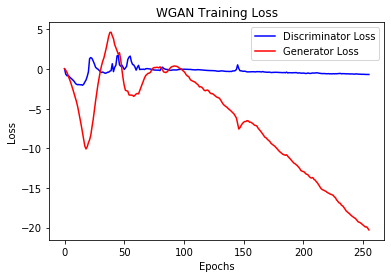

In [15]:
plt.plot(range(W_EPOCH), wld, color = "blue", label = "Discriminator Loss")
plt.plot(range(W_EPOCH), wlg, color = "red", label = "Generator Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN Training Loss")
plt.show()